# Random Forest (sklearn) vs XGBoost

## sklearn.ensemble.RandomForestClassifier

In [2]:
from sklearn import ensemble , model_selection, learning_curve, metrics 

import numpy as np
import pandas as pd
import xgboost as xgb

C:\Users\shust\Anaconda3\envs\py27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\shust\Anaconda3\envs\py27\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Данные

Задача на kaggle: https://www.kaggle.com/c/bioresponse

Данные: https://www.kaggle.com/c/bioresponse/data

По данным характеристикам молекулы требуется определить, будет ли дан биологический ответ (biological response).

Признаки нормализаваны.

Для демонстрации используется обучающая выборка из исходных данных train.csv, файл с данными прилагается.

In [4]:
bioresponce = pd.read_csv('../seminar1/bioresponse.csv', header=0, sep=',')

In [5]:
bioresponce.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [6]:
bioresponce_target = bioresponce.Activity.values

In [7]:
bioresponce_data = bioresponce.iloc[:, 1:]

## Зависимость качества от количества деревьев

### RandomForestClassifier

In [8]:
n_trees = [1] + range(10, 110, 10) 

In [9]:
%%time
scoring = []
for n_tree in n_trees:
    estimator = ensemble.RandomForestClassifier(n_estimators = n_tree, min_samples_split=5, random_state=1)
    score = model_selection.cross_val_score(
        estimator, bioresponce_data, bioresponce_target, 
        scoring = 'accuracy', cv = 3
    )    
    scoring.append(score)
scoring = np.asmatrix(scoring)

Wall time: 29.3 s


In [10]:
scoring

matrix([[ 0.66906475,  0.668     ,  0.6712    ],
        [ 0.75939249,  0.7592    ,  0.7504    ],
        [ 0.7833733 ,  0.7736    ,  0.7648    ],
        [ 0.78816946,  0.7752    ,  0.7736    ],
        [ 0.78976819,  0.78      ,  0.784     ],
        [ 0.79616307,  0.7832    ,  0.792     ],
        [ 0.79056755,  0.7816    ,  0.7936    ],
        [ 0.78816946,  0.776     ,  0.792     ],
        [ 0.79456435,  0.7824    ,  0.796     ],
        [ 0.79776179,  0.7824    ,  0.7968    ],
        [ 0.78976819,  0.7896    ,  0.7944    ]])

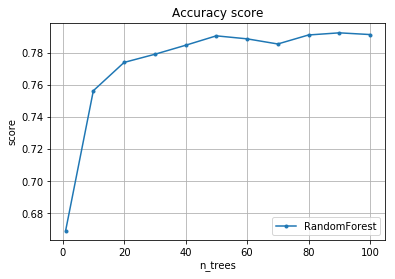

In [11]:
pylab.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

### XGBoost

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import *

In [60]:
xgb_model = xgb.XGBClassifier()

#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters = {#'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic', 'reg:linear'],
              'learning_rate': [0.001, 0.01, 0.1], #so called `eta` value
              'max_depth': [3, 5, 7],
              'min_child_weight': [3, 5],
#              'silent': [1],
              'subsample': [0.8, 0.9],
              'colsample_bytree': [0.7, 0.3],
              'n_estimators': [50], #number of trees, change it to 1000 for better results
#              'seed': [1337]
}

clf = GridSearchCV(xgb_model, parameters, n_jobs=-1, 
                   cv=3, 
                   scoring='accuracy',
                   verbose=7, refit=True)

clf.fit(bioresponce_data, bioresponce_target)

#trust your CV!
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

#test_probs = clf.predict_proba(test[features])[:,1]

#sample = pd.read_csv('../input/sample_submission.csv')
#sample.QuoteConversion_Flag = test_probs
#sample.to_csv("xgboost_best_parameter_submission.csv", index=False)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 17.9min finished


('Raw score:', 0.79578778992268728)
colsample_bytree: 0.7
learning_rate: 0.1
max_depth: 7
min_child_weight: 5
n_estimators: 50
objective: 'reg:linear'
subsample: 0.8


C:\Users\shust\Anaconda3\envs\py27\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


('Raw score:', 0.79765395894428148)
learning_rate: 0.1
max_depth: 8
min_child_weight: 11
n_estimators: 100
  
estimator = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=n_tree, min_child_weight=3)
matrix([[ 0.76498801,  0.756     ,  0.756     ],
        [ 0.77617906,  0.7752    ,  0.7688    ],
        [ 0.77857714,  0.7744    ,  0.7768    ],
        [ 0.7873701 ,  0.7784    ,  0.7768    ],
        [ 0.79216627,  0.7736    ,  0.7832    ],
        [ 0.79776179,  0.7776    ,  0.7824    ],
        [ 0.79616307,  0.7816    ,  0.78      ],
        [ 0.79296563,  0.7848    ,  0.7792    ],
        [ 0.79856115,  0.7832    ,  0.7808    ],
        [ 0.79936051,  0.7832    ,  0.7832    ]])

In [65]:
%%time
xgb_scoring = []
for n_tree in n_trees:
    estimator = xgb.XGBClassifier(learning_rate=0.1, max_depth=7, n_estimators=n_tree, min_child_weight=5, colsample_bytree=0.7, subsample = 0.8, objective = 'reg:linear')
    score = model_selection.cross_val_score(
        estimator, bioresponce_data, bioresponce_target,
        scoring = 'accuracy', cv = 3
    )    
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

Wall time: 2min 24s


In [ ]:
colsample_bytree: 0.7
learning_rate: 0.1
max_depth: 7
min_child_weight: 5
n_estimators: 50
objective: 'reg:linear'
subsample: 0.8

In [66]:
xgb_scoring

matrix([[ 0.71782574,  0.748     ,  0.756     ],
        [ 0.77857714,  0.7792    ,  0.8008    ],
        [ 0.78976819,  0.784     ,  0.7968    ],
        [ 0.79056755,  0.7872    ,  0.8       ],
        [ 0.79216627,  0.7832    ,  0.8       ],
        [ 0.79616307,  0.7904    ,  0.8008    ],
        [ 0.79456435,  0.7888    ,  0.8032    ],
        [ 0.79696243,  0.788     ,  0.8064    ],
        [ 0.80015987,  0.7832    ,  0.7992    ],
        [ 0.80015987,  0.7864    ,  0.7984    ],
        [ 0.79936051,  0.7832    ,  0.8       ]])

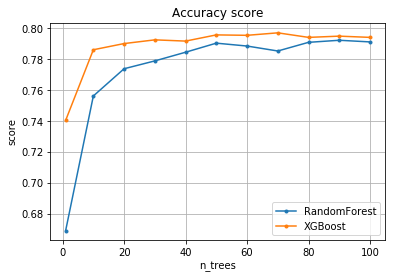

In [67]:
pylab.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
pylab.plot(n_trees, xgb_scoring.mean(axis = 1), marker='.', label='XGBoost')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

#### **Материалы по xgboost:**
python api: http://xgboost.readthedocs.org/en/latest/python/python_api.html

установка: http://xgboost.readthedocs.org/en/latest/python/python_intro.html#install-xgboost

#### Неплохой гайд по установке под windows

https://www.ibm.com/developerworks/community/blogs/jfp/entry/Installing_XGBoost_For_Anaconda_on_Windows?lang=ru

## Задание:

1. Поставить XGBoost так, чтобы примеры из этого блокнота у вас работали
1. Поиграйтесь на этом датасете с параметрами градиентного бустинга, и посмотрите, как изменение отдельных параметров влияет на результат.

# Код оценки качества

#### Подробности о том как присылать решения и в каком формате - позже

#### Итак ваша цель сказать значение параметров xgb, при которых будет самое хорошее качество на кроссвалидации

In [14]:
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import pandas
import numpy as np
import signal

bioresponce = pandas.read_csv('../seminar1/bioresponse.csv', header=0, sep=',')
bioresponce_target = bioresponce.Activity.values
bioresponce_data = bioresponce.iloc[:, 1:]

def signal_handler(signum, frame):
    raise Exception("Timed out!")

def estimate_params(params):
    #signal.signal(signal.SIGALRM, signal_handler)
    #signal.alarm(30)
    estimator = xgb.XGBClassifier(**params)
    try:
        score = np.mean(model_selection.cross_val_score(
            estimator, bioresponce_data, bioresponce_target,
            scoring = 'accuracy', cv = 3
        ))
    except Exception, msg:
        score = None
    
    return score

In [ ]:
0
0.781125286438
1
0.788322728484
2
0.780060325073
3
0.783791739941
4

In [ ]:
%%time
#my_current

maxx = 0
maxi = 0
for i in range(0, 1, 0.01) :
    x = estimate_params({
        'objective' : 'reg:linear',
        'subsample' : 0.8,    
        'colsample_bytree' : 0.7,
        'learning_rate': i, 
        'max_depth': 7, 
        'n_estimators': 10, 
        'min_child_weight': 3,
        'seed': ?
    })
    if x > maxx :
        maxx = x
        maxi = i
        print(i, x)

In [ ]:
colsample_bytree: 0.7
learning_rate: 0.1
max_depth: 7
min_child_weight: 5
n_estimators: 50
objective: 'reg:linear'
subsample: 0.8

In [73]:
%%time
#my_current

maxx = 0
maxi = 0
for i in range(1000) :
    x = estimate_params({
        'objective' : 'reg:linear',
        'subsample' : 0.8,    
        'colsample_bytree' : 0.7,
        'learning_rate': 0.1, 
        'max_depth': 7, 
        'n_estimators': 100, 
        'min_child_weight': 5,
        'seed': i
    })
    if x > maxx :
        maxx = x
        maxi = i
        print(i, x)
        

(0, 0.7941868371969093)
(1, 0.79898555822009065)
(9, 0.80165222488675736)
(31, 0.80485009325872625)
(108, 0.80618427924327207)


KeyboardInterrupt: 

In [ ]:
(0, 0.7941868371969093)
(1, 0.79898555822009065)
(9, 0.80165222488675736)
(31, 0.80485009325872625)
(108, 0.80618427924327207)

In [58]:
%%time
#my_best

print estimate_params({
    'objective' : 'reg:linear',
    'subsample' : 0.8,    
    'colsample_bytree' : 0.7,
    'learning_rate': 0.08, 
    'max_depth': 7, 
    'n_estimators': 100, 
    'min_child_weight': 3,
    'seed': 1
})

0.800319957367
Wall time: 26.9 s


In [15]:
%%time
#base

print estimate_params({
    'objective' : 'reg:linear',
    'subsample' : 0.8,    
    'colsample_bytree' : 0.7,
    'learning_rate': 0.1, 
    'max_depth': 7, 
    'n_estimators': 100, 
    'min_child_weight': 5,
    'seed': 108
})

0.806184279243
Wall time: 24.8 s


In [36]:
%%time
#base

print estimate_params({
    'learning_rate': 0.1, 
    'max_depth': 5, 
    'n_estimators': 100, 
    'min_child_weight': 3,
    'seed': 108
})

0.791254356515
Wall time: 26.6 s


In [26]:
%%time
#shit

print estimate_params({
    'learning_rate': 0.1, 
    'max_depth': 5, 
    'n_estimators': 100000, 
    'min_child_weight': 3,
    'seed': 42
})

KeyboardInterrupt: 